## Pytorch for Binary Classification

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,\
recall_score,roc_curve,auc

## check available device
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print("device:", device)

##-----
#init_random_seed(random_seed=42)

device: cpu


In [2]:
max_epochs,patience = 50,20

In [3]:
data = load_breast_cancer()
x = data['data']
y = data['target']

print(x.shape, y.shape)
print(x[:5])
print(y[:5])

(569, 30) (569,)
[[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
  1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
  6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
  1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
  4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 1.326e+03 8.474e-02 7.864e-02 8.690e-02
  7.017e-02 1.812e-01 5.667e-02 5.435e-01 7.339e-01 3.398e+00 7.408e+01
  5.225e-03 1.308e-02 1.860e-02 1.340e-02 1.389e-02 3.532e-03 2.499e+01
  2.341e+01 1.588e+02 1.956e+03 1.238e-01 1.866e-01 2.416e-01 1.860e-01
  2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 1.203e+03 1.096e-01 1.599e-01 1.974e-01
  1.279e-01 2.069e-01 5.999e-02 7.456e-01 7.869e-01 4.585e+00 9.403e+01
  6.150e-03 4.006e-02 3.832e-02 2.058e-02 2.250e-02 4.571e-03 2.357e+01
  2.553e+01 1.525e+02 1.709e+03 1.444e-01 4.245e-01 4.504e-01 2.430e-01
  3.613e-01 8.758e-02]
 [1.142e+01 2.038e+01 7.758e+01 3.861e+02 1.425e-0

In [4]:
train_idx, valid_idx = train_test_split(np.arange(y.shape[0]), test_size=0.4, shuffle=True)
print(train_idx.shape, valid_idx.shape)

x_train = x[train_idx]
x_valid = x[valid_idx]

y_train = y[train_idx]
y_valid = y[valid_idx]

(341,) (228,)


In [5]:
## feature scaling
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)

In [6]:
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length

trainset = dataset(x_train,y_train)
validset = dataset(x_valid,y_valid)

#DataLoader
train_loader = DataLoader(trainset,batch_size=64,shuffle=True)
valid_loader = DataLoader(validset,batch_size=64,shuffle=False)

In [7]:
class Net(nn.Module):
  def __init__(self,input_shape):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_shape,32)
    self.fc2 = nn.Linear(32,64)
    self.fc3 = nn.Linear(64,1)
    
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    
    return x

In [8]:
learning_rate = 0.002
epochs = 200

# Model , Optimizer, Loss
model = Net(input_shape=x.shape[1])
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

In [9]:
def training_epoch(model, optimizer, train_loader,loss_fn):
    model.train()

    labels = []
    preds = []
    loss_list = []
    acc_list = []
    for x,y in train_loader:       ## repeat times = len(train_set)/batch_size
        #print("x.shape:", x.shape)
        #print("y.shape:", y.shape)

        labels += [y.reshape(-1).detach().cpu().numpy()]

        pred = model(x.float().to(device))       
        #print("pred.shape:", pred.shape)
        
        preds += [pred.reshape(-1).detach().cpu().numpy()]

        loss = loss_fn(pred, y.float().to(device).reshape(-1,1))
        loss_list += [loss.detach().cpu().numpy()] ## add loss of each sample to a list

        ## reset gradients to zero
        optimizer.zero_grad()

        ## compute gradients
        loss.backward()

        ## update parameters using gradients
        optimizer.step()
    
        #if i%20 == 0:
        #    loss1 = loss.detach().cpu().numpy()
        #    loss_list.append(loss1)
        #    acc_list.append(acc)
        #    print("epoch {}\tloss : {}\t acc : {}".format(i,loss1,acc))
        
        
        
    return np.mean(loss_list) #,np.mean(coef),np.mean(slope)

In [10]:
def predict(model, dataloader, loss_fn):
    model.eval()
    
    labels = []
    preds = []
    loss_list = []

    with torch.no_grad():
        for x, y in dataloader:         ## load x, y from dataloader for each batch
            
            labels += [y.reshape(-1).detach().cpu().numpy()]  ## y_actual
            pred = model(x.float().to(device))                ## y_pred = model(x)

            loss = loss_fn(pred, y.float().to(device).reshape(-1,1))
            loss_list += [loss.detach().cpu().numpy()] ## convert to numpy

            #pred = nn.ReLU()(pred)                    ## y_pred
            preds += [pred.reshape(-1).detach().cpu().numpy()]     ## convert to numpy
    
    ## convert list to 2D array
    labels = np.concatenate(labels)
    preds = np.concatenate(preds)
        
    #coef,slope = compute_coef_slope(labels, preds)
    
    return np.mean(loss_list),labels,preds

In [11]:
train_loss_list = []
valid_loss_list = []

train_acc_list = []

valid_acc_list = []
valid_precision_list = []
valid_recall_list = []

epoch_since_best = 0
valid_coef_old = -1.
for e in range(max_epochs):
    epoch_since_best += 1

    ## train
    train_loss = training_epoch(model, optimizer, train_loader, loss_fn)

    ## predict
    train_loss, train_labels, train_preds_prob = predict(model, train_loader, loss_fn)
    valid_loss, valid_labels, valid_preds_prob = predict(model, valid_loader, loss_fn)
    
    train_preds = train_preds_prob.round()
    valid_preds = valid_preds_prob.round()
    
    train_acc = accuracy_score(train_labels, train_preds)
    valid_acc = accuracy_score(valid_labels, valid_preds)
    valid_precision = precision_score(valid_labels, valid_preds)
    valid_recall = recall_score(valid_labels, valid_preds)
    
    ##--------------------------
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    
    train_acc_list.append(train_acc)
    valid_acc_list.append(valid_acc)
    valid_precision_list.append(valid_precision)
    valid_recall_list.append(valid_recall)

No handles with labels found to put in legend.


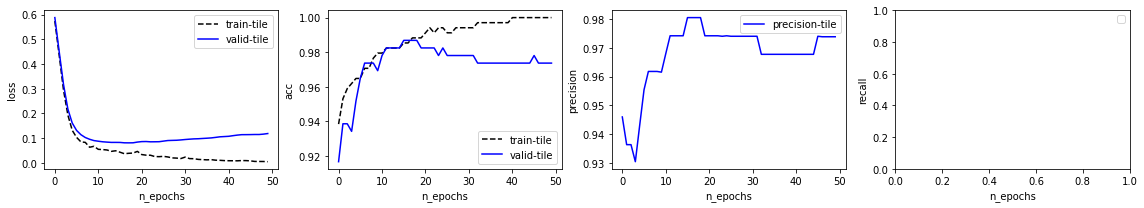

In [12]:
nx,ny = 4,1
fig, ax = plt.subplots(ny,nx,figsize=(nx*4,ny*3))
ax[0].plot(train_loss_list, 'k--', label="train-tile")
ax[0].plot(valid_loss_list, 'b-', label="valid-tile")

ax[1].plot(train_acc_list, 'k--', label="train-tile")
ax[1].plot(valid_acc_list, 'b-', label="valid-tile")

ax[2].plot(valid_precision_list, 'b-', label="precision-tile")

for i in range(nx):
    ax[i].set_xlabel("n_epochs")
    ax[i].legend()

ax[0].set_ylabel("loss")
ax[1].set_ylabel("acc")
ax[2].set_ylabel("precision")
ax[3].set_ylabel("recall")

plt.tight_layout(h_pad=1, w_pad= 0.5)
#plt.savefig("loss.pdf", format='pdf', dpi=50)